In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os
import time
from datetime import datetime, timedelta

In [9]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')  # August 10, 2025
data = {}

def download_fallback(ticker, start, end):
    """Fallback using yf.Ticker.history"""
    try:
        ticker_obj = yf.Ticker(ticker)
        df = ticker_obj.history(start=start, end=end, raise_errors=True)
        if not df.empty:
            return df
        else:
            raise Exception(f"Empty data for {ticker}")
    except Exception as e:
        raise Exception(f"Fallback failed for {ticker}: {e}")

for ticker in tickers:
    downloaded = False
    for attempt in range(5):
        try:
            df = yf.download(ticker, start=start_date, end=end_date, progress=False, ignore_tz=True, threads=False, repair=True)
            if not df.empty:
                data[ticker] = df
                data[ticker].to_csv(f'../data/raw/{ticker.lower()}_data.csv')
                print(f"Downloaded {ticker} data (attempt {attempt+1})")
                downloaded = True
                break
            else:
                raise Exception(f"Empty data for {ticker}")
        except Exception as e:
            print(f"Error downloading {ticker} with yf.download: {e}. Trying fallback...")
            try:
                df = download_fallback(ticker, start_date, end_date)
                data[ticker] = df
                data[ticker].to_csv(f'../data/raw/{ticker.lower()}_data.csv')
                print(f"Downloaded {ticker} data via fallback (attempt {attempt+1})")
                downloaded = True
                break
            except Exception as e2:
                print(f"Fallback failed for {ticker}: {e2}. Retrying in 10 seconds...")
                time.sleep(10)
    if not downloaded:
        raise Exception(f"Failed to download {ticker} after 5 attempts. Check internet or try later.")

C:\Users\zyona\AppData\Local\Temp\ipykernel_2996\330922612.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False, ignore_tz=True, threads=False, repair=True)
C:\Users\zyona\AppData\Local\Temp\ipykernel_2996\330922612.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False, ignore_tz=True, threads=False, repair=True)


Downloaded TSLA data (attempt 1)
Downloaded BND data (attempt 1)


C:\Users\zyona\AppData\Local\Temp\ipykernel_2996\330922612.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False, ignore_tz=True, threads=False, repair=True)


Downloaded SPY data (attempt 1)


In [11]:
try:
    # Try standard yfinance CSV format
    tsla = pd.read_csv('../data/raw/tsla_data.csv', index_col='Date', parse_dates=True)
    tsla = tsla['Adj Close' if 'Adj Close' in tsla.columns else 'Close'].rename('TSLA')
    bnd = pd.read_csv('../data/raw/bnd_data.csv', index_col='Date', parse_dates=True)
    bnd = bnd['Adj Close' if 'Adj Close' in bnd.columns else 'Close'].rename('BND')
    spy = pd.read_csv('../data/raw/spy_data.csv', index_col='Date', parse_dates=True)
    spy = spy['Adj Close' if 'Adj Close' in spy.columns else 'Close'].rename('SPY')
except ValueError:
    # Handle non-standard CSV format (e.g., sample data with Ticker row)
    print("Standard CSV read failed. Trying non-standard format...")
    try:
        tsla = pd.read_csv('../data/raw/tsla_data.csv', skiprows=2, index_col=0, parse_dates=True)
        tsla = tsla[tsla['Ticker'] == 'TSLA']['Close'].rename('TSLA')
        bnd = pd.read_csv('../data/raw/bnd_data.csv', skiprows=2, index_col=0, parse_dates=True)
        bnd = bnd[bnd['Ticker'] == 'BND']['Close'].rename('BND')
        spy = pd.read_csv('../data/raw/spy_data.csv', skiprows=2, index_col=0, parse_dates=True)
        spy = spy[spy['Ticker'] == 'SPY']['Close'].rename('SPY')
    except Exception as e:
        raise Exception(f"Failed to read CSVs: {e}. Ensure correct format or re-run download.")

combined = pd.concat([tsla, bnd, spy], axis=1)

In [12]:
combined = combined.asfreq('B').ffill()
print("Data types:\n", combined.dtypes)
print("Missing values:\n", combined.isnull().sum())

Data types:
 TSLA    float64
BND     float64
SPY     float64
dtype: object
Missing values:
 TSLA    0
BND     0
SPY     0
dtype: int64


In [13]:
print("Summary statistics:\n", combined.describe())

Summary statistics:
               TSLA          BND          SPY
count  2638.000000  2638.000000  2638.000000
mean    132.812093    68.483180   335.236012
std     121.562743     4.552257   127.366344
min       9.488000    60.786656   155.426530
25%      18.979167    64.666069   231.566968
50%      98.238667    67.620588   305.702956
75%     236.882500    71.890220   421.692936
max     475.899994    77.378764   639.460022


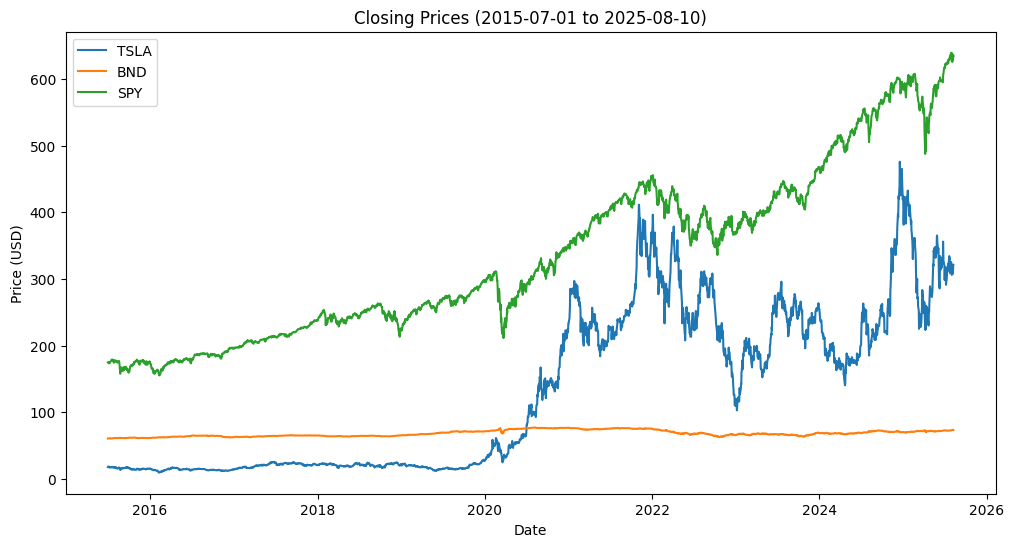

In [15]:
plt.figure(figsize=(12,6))
for col in combined.columns:
    plt.plot(combined[col], label=col)
plt.title(f'Closing Prices ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('../reports/figures/closing_prices.png')
plt.show()

In [16]:
returns = combined.pct_change().dropna()
print("First 5 daily returns:\n", returns.head())

First 5 daily returns:
                 TSLA       BND       SPY
Date                                    
2015-07-02  0.033529  0.002350  0.001637
2015-07-03  0.000000  0.000000  0.000000
2015-07-06 -0.004711  0.004688 -0.011054
2015-07-07 -0.013913  0.003070  0.005783
2015-07-08 -0.057018 -0.000613 -0.002609


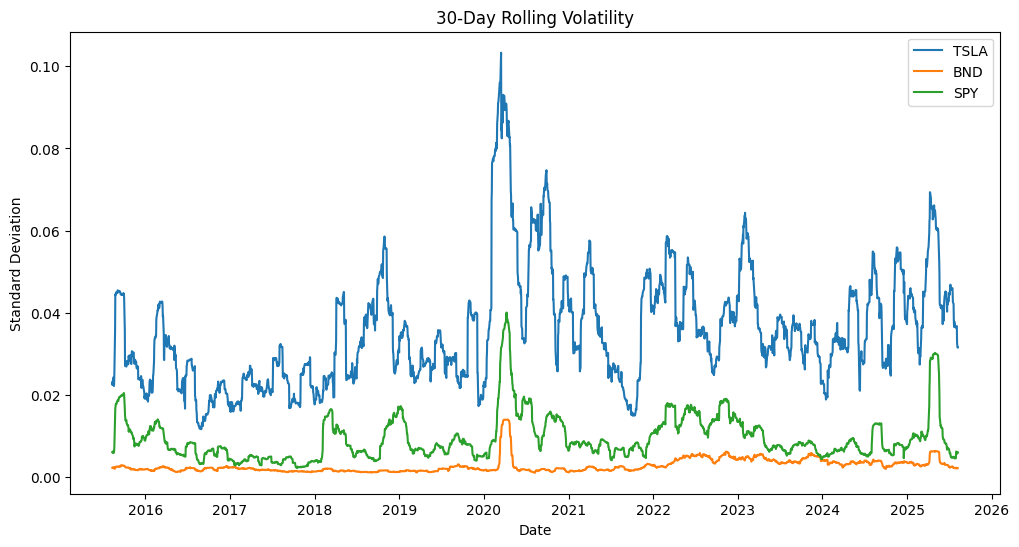

In [18]:
rolling_std = returns.rolling(window=30).std()
plt.figure(figsize=(12,6))
for col in rolling_std.columns:
    plt.plot(rolling_std[col], label=col)
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.savefig('../reports/figures/rolling_volatility.png')
plt.show()

In [19]:
outliers = returns[np.abs(returns) > 3 * returns.std()]
print("Outliers (returns > 3 std):\n", outliers.dropna(how='all'))

Outliers (returns > 3 std):
                 TSLA       BND       SPY
Date                                    
2015-08-24 -0.140720       NaN -0.070589
2015-08-25  0.136742       NaN  0.042349
2015-10-05       NaN       NaN  0.035253
2018-02-06       NaN       NaN -0.049406
2018-02-07       NaN       NaN  0.032931
...              ...       ...       ...
2025-04-09       NaN -0.019610 -0.054459
2025-04-10  0.157150  0.013009  0.078490
2025-04-11       NaN -0.010080       NaN
2025-04-14       NaN       NaN  0.040229
2025-04-23       NaN       NaN  0.039009

[101 rows x 3 columns]


In [20]:
for col in combined.columns:
    adf_result = adfuller(combined[col])
    print(f'ADF Test for {col} Close: p-value = {adf_result[1]}')
    adf_returns = adfuller(returns[col])
    print(f'ADF Test for {col} Returns: p-value = {adf_returns[1]}')

ADF Test for TSLA Close: p-value = 0.551579887592883
ADF Test for TSLA Returns: p-value = 1.167418167846646e-29
ADF Test for BND Close: p-value = 0.5008386914326699
ADF Test for BND Returns: p-value = 0.0
ADF Test for SPY Close: p-value = 0.9889537443731455
ADF Test for SPY Returns: p-value = 0.0


In [21]:
var_95 = returns.quantile(0.05)
print("95% VaR (Historical):\n", var_95)
sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
print("Sharpe Ratios:\n", sharpe)

95% VaR (Historical):
 TSLA   -0.056075
BND    -0.004640
SPY    -0.017156
Name: 0.05, dtype: float64
Sharpe Ratios:
 TSLA    0.754102
BND     0.381003
SPY     0.799877
dtype: float64


In [23]:
combined.to_csv('../data/processed/combined_data.csv')
print("Processed data saved to data/processed/combined_data.csv")

Processed data saved to data/processed/combined_data.csv
